## AutoEncoder Test with MNIST data v2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Get CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# get pytorch version
version = torch.__version__
print("Pytorch version: {}".format(version))

Pytorch version: 2.0.1+cu118


### Model Definition
In first test I used 784-128-64-32 model but I saw it`s incapable to learn so I made bigger that 784-256-128-64-32

### Loss and Optimizer
Adam is ok. But small learning rate is important for big output data like 784

Loss function is very IMPORTANT. I tried BCEWithLogitsLoss, CrossEntropyLoss but best MSELoss

In [26]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim,dtype=torch.float32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256, dtype=dtype),
            nn.ReLU(),
            nn.Linear(256, 128, dtype=dtype),
            nn.ReLU(),
            nn.Linear(128, 64, dtype=dtype),
            nn.ReLU(),
            nn.Linear(64, encoding_dim, dtype=dtype)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64, dtype=dtype),
            nn.ReLU(),
            nn.Linear(64, 128, dtype=dtype),
            nn.ReLU(),
            nn.Linear(128, 256, dtype=dtype),
            nn.ReLU(),
            nn.Linear(256, input_dim, dtype=dtype),            
            nn.Sigmoid()  # Use sigmoid activation for pixel values between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
input_dim = 784  # Input dimension for MNIST images (28x28 pixels = 784)
encoding_dim = 16  # Dimension of the encoded representation

data_type = torch.float32

model = Autoencoder(input_dim, encoding_dim,data_type).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epoch = 0

Load the model from the file

In [4]:
# load checkpoint
# Define the paths for saving and loading checkpoints
checkpoint_path = 'mnist_ae_v2_checkpoint.pth'
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
except:
    print("No checkpoint found")


No checkpoint found


Load Dataset

In [27]:
# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
train_dataset.data = train_dataset.data.to(device)
# Create dataloaders
batch_size = 128

In [28]:
# Copy Dataset to GPU with random batches
batch_count = len(train_dataset) // batch_size
print("Batch Count: {}".format(batch_count))
gpu_tensor = torch.Tensor(batch_count, batch_size,784).to(device, dtype=data_type)

for i in range(batch_count):
    gpu_tensor[i] = train_dataset.data[i*batch_size:(i+1)*batch_size].view(batch_size,784).to(device)
    gpu_tensor[i] = gpu_tensor[i] / 255.0


Batch Count: 468


Random 10 images from dataset, latent_space and output:


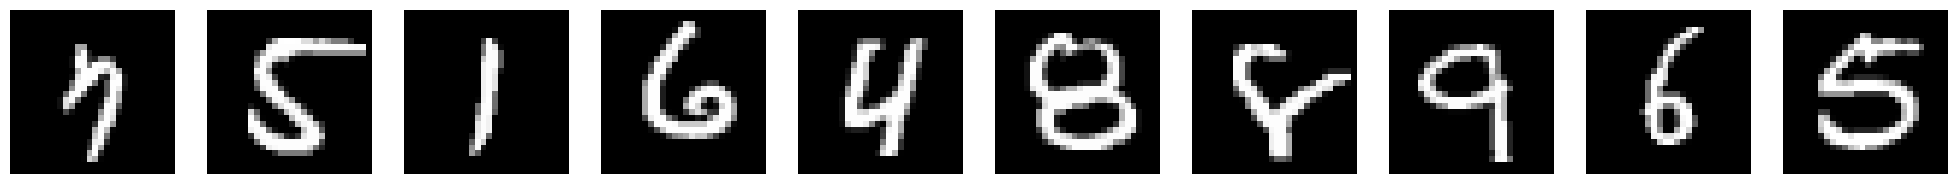

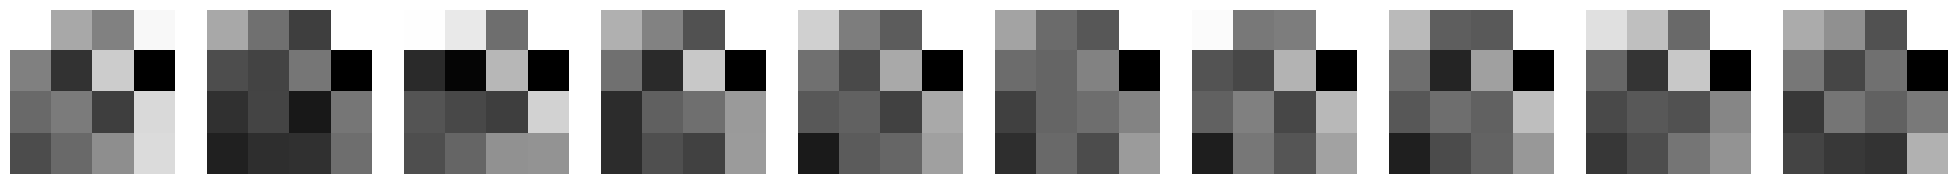

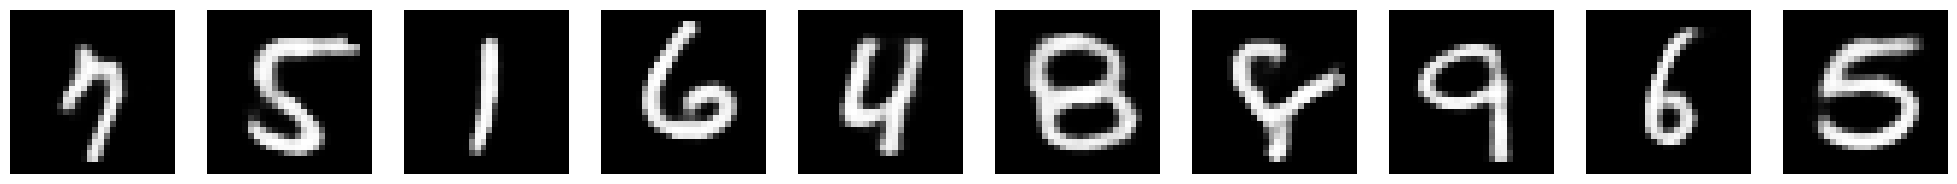

In [38]:
def plot_images(images,w,h):
    n_images = len(images)
    rows = 1
    cols = n_images
    fig = plt.figure(figsize=(25, 4))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(w,h).cpu().numpy(), cmap='gray')
        ax.axis('off')

# Plot the first 10 images

print('Random 10 images from dataset, latent_space and output:')
rn = np.random.randint(0,batch_count)
plot_images(gpu_tensor[rn][10:20],28,28)
latent_space = model.encoder(gpu_tensor[rn][10:20])
plot_images(latent_space.cpu().detach(),4,4)
outputs = model.decoder(latent_space)
plot_images(outputs.cpu().detach(),28,28)

Training

In [36]:
# Training loop
import time
num_epochs = 250
end_epoch = epoch + num_epochs

# Shuffle tensor, not using now
idx = torch.arange(batch_count)
shuffled_idx = idx[torch.randperm(batch_count)]

st_time = time.time()
for ep in range(epoch,end_epoch):
    epoch = ep + 1  
    for i in range(batch_count):
        optimizer.zero_grad()
        inputs = gpu_tensor[i]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()    
    if (ep+1) % 10 == 0:
        e_time = time.time()
        print(f"Epoch [{ep+1}/{end_epoch}], Loss: {loss.item():.4f}, Time: {e_time-st_time:.4f} sec")
        st_time = time.time()
print('Finished Training. last epoch = {}'.format(epoch))

Epoch [260/500], Loss: 0.0081, Time: 9.2310 sec
Epoch [270/500], Loss: 0.0080, Time: 9.2500 sec
Epoch [280/500], Loss: 0.0080, Time: 9.2534 sec
Epoch [290/500], Loss: 0.0079, Time: 9.2281 sec
Epoch [300/500], Loss: 0.0078, Time: 9.2312 sec
Epoch [310/500], Loss: 0.0078, Time: 9.2188 sec
Epoch [320/500], Loss: 0.0078, Time: 9.2574 sec
Epoch [330/500], Loss: 0.0077, Time: 9.2208 sec
Epoch [340/500], Loss: 0.0077, Time: 9.2806 sec
Epoch [350/500], Loss: 0.0076, Time: 9.3371 sec
Epoch [360/500], Loss: 0.0076, Time: 9.1860 sec
Epoch [370/500], Loss: 0.0076, Time: 9.1819 sec
Epoch [380/500], Loss: 0.0075, Time: 9.2113 sec
Epoch [390/500], Loss: 0.0075, Time: 9.1929 sec
Epoch [400/500], Loss: 0.0075, Time: 9.2100 sec
Epoch [410/500], Loss: 0.0074, Time: 9.1830 sec
Epoch [420/500], Loss: 0.0074, Time: 9.1825 sec
Epoch [430/500], Loss: 0.0074, Time: 9.1995 sec
Epoch [440/500], Loss: 0.0074, Time: 9.2177 sec
Epoch [450/500], Loss: 0.0073, Time: 9.2289 sec
Epoch [460/500], Loss: 0.0073, Time: 9.2

Save the Checkpoint

In [35]:
# Save checkpoint
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
}, checkpoint_path)